In [1]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets
from torchvision import transforms
from torch.optim import Adam
from tqdm import tqdm
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Создание и нормализация обучающей, тестовой и выборки валидации

batch_size = 128

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Resize((128, 128)),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_path = "C:/Users/das-s/Downloads/Faces/train"
train_ds = datasets.ImageFolder(root=train_path, transform=transform)
train_dataloader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, pin_memory=True, drop_last=True)

test_path = "C:/Users/das-s/Downloads/Faces/test"
test_ds = datasets.ImageFolder(root=test_path, transform=transform)
test_dataloader = DataLoader(test_ds, batch_size=batch_size, shuffle=True, pin_memory=True, drop_last=True)

validation_path = "C:/Users/das-s/Downloads/Faces/val"
validation_ds = datasets.ImageFolder(root=validation_path, transform=transform)
validation_dataloader = DataLoader(validation_ds, batch_size=batch_size, shuffle=True, pin_memory=True, drop_last=True)

In [4]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

c:\Users\das-s\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Feature batch shape: torch.Size([128, 3, 128, 128])
Labels batch shape: torch.Size([128])


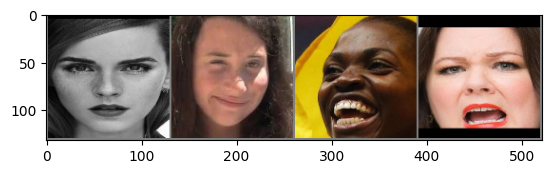

Neutral	 Happy	 Happy	 Angry	


In [5]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
images = []
for i in range(4):
    images.append(train_features[i])
imshow(torchvision.utils.make_grid(images)) # show images
print(' '.join(f'{train_ds.classes[train_labels[j]]}\t' for j in range(4))) # print labels


In [6]:
class CNN(nn.Module):
    def __init__(self, channel, num_classes):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(nn.Conv2d(channel, 32, kernel_size=3),
                                    nn.BatchNorm2d(32),
                                    nn.ReLU(),
                                    nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(nn.Conv2d(32, 64, kernel_size=3),
                                    nn.BatchNorm2d(64),
                                    nn.ReLU(),
                                    nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer3 = nn.Sequential(nn.Conv2d(64, 128, kernel_size=3),
                                    nn.ReLU(),
                                    nn.Conv2d(128, 128, kernel_size=3),
                                    nn.BatchNorm2d(128),
                                    nn.ReLU(),
                                    nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer4 = nn.Sequential(nn.Conv2d(128, 256, kernel_size=3),
                                    nn.ReLU(),
                                    nn.Conv2d(256, 256, kernel_size=3),
                                    nn.ReLU(),
                                    nn.Conv2d(256, 256, kernel_size=3),
                                    nn.BatchNorm2d(256),
                                    nn.ReLU(),
                                    nn.MaxPool2d(kernel_size=2, stride=2))

        self.fc1 = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(256*3*3, 512),
            nn.ReLU())
        self.fc2 = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(512, 128),
            nn.ReLU())
        self.fc3 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = x.view(-1, 256*3*3)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return nn.functional.softmax(x, dim=1)

In [7]:
model = CNN(3, len(test_ds.classes))
model.to(device)

CNN(
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    

In [8]:
def train(model, train_dataloader, optimizer, loss_func):
    model.train()
    print('Train')
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    for data, labels in tqdm(train_dataloader):
        counter += 1
        data = data.to(device)
        labels = labels.to(device)

        outputs = model(data)
        # calculate the loss
        loss = loss_func(outputs, labels)
        train_running_loss += loss.item()
        # calculate the accuracy
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == labels).sum().item()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    # loss and accuracy for the complete epoch
    epoch_loss = train_running_loss / counter
    epoch_acc = 100. * (train_running_correct / len(train_dataloader.dataset))
    return epoch_loss, epoch_acc

In [9]:
def validate(model, validation_dataloader, loss_func):
    model.eval()
    print('Validation')
    valid_running_loss = 0.0
    valid_running_correct = 0
    counter = 0
    with torch.no_grad():
        for data, labels in tqdm(validation_dataloader):
            counter += 1
            data = data.to(device)
            labels = labels.to(device)
            # forward pass
            outputs = model(data)
            # calculate the loss
            loss = loss_func(outputs, labels)
            valid_running_loss += loss.item()
            # calculate the accuracy
            _, preds = torch.max(outputs.data, 1)
            valid_running_correct += (preds == labels).sum().item()
        
    # loss and accuracy for the complete epoch
    epoch_loss = valid_running_loss / counter
    epoch_acc = 100. * (valid_running_correct / len(validation_dataloader.dataset))
    return epoch_loss, epoch_acc

In [10]:
optimizer = Adam(params=model.parameters(), lr=1e-3)
loss_func = nn.CrossEntropyLoss()
num_epochs = 30

In [11]:
train_loss, valid_loss = [], []
train_acc, valid_acc = [], []

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1} of {num_epochs}")
    train_epoch_loss, train_epoch_acc = train(model, train_dataloader, 
                                              optimizer, loss_func)
    valid_epoch_loss, valid_epoch_acc = validate(model, validation_dataloader,  
                                                 loss_func)
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    train_acc.append(train_epoch_acc)
    valid_acc.append(valid_epoch_acc)
    print(f"Training loss: {train_epoch_loss:.3f}, validation loss: {valid_epoch_loss:.3f}")
    print(f"Training acc: {train_epoch_acc:.3f}, validation acc: {valid_epoch_acc:.3f}")

Epoch 1 of 30
Train


100%|██████████| 111/111 [01:07<00:00,  1.65it/s]


Validation


100%|██████████| 7/7 [00:04<00:00,  1.75it/s]


Training loss: 1.468, validation loss: 1.552
Training acc: 41.297, validation acc: 30.714
Epoch 2 of 30
Train


100%|██████████| 111/111 [01:03<00:00,  1.74it/s]


Validation


100%|██████████| 7/7 [00:03<00:00,  1.94it/s]


Training loss: 1.373, validation loss: 1.522
Training acc: 52.077, validation acc: 33.265
Epoch 3 of 30
Train


100%|██████████| 111/111 [01:02<00:00,  1.78it/s]


Validation


100%|██████████| 7/7 [00:03<00:00,  1.98it/s]


Training loss: 1.353, validation loss: 1.486
Training acc: 54.001, validation acc: 37.143
Epoch 4 of 30
Train


100%|██████████| 111/111 [01:02<00:00,  1.78it/s]


Validation


100%|██████████| 7/7 [00:03<00:00,  1.86it/s]


Training loss: 1.331, validation loss: 1.473
Training acc: 56.457, validation acc: 37.755
Epoch 5 of 30
Train


100%|██████████| 111/111 [01:02<00:00,  1.78it/s]


Validation


100%|██████████| 7/7 [00:03<00:00,  1.99it/s]


Training loss: 1.320, validation loss: 1.477
Training acc: 57.643, validation acc: 37.857
Epoch 6 of 30
Train


100%|██████████| 111/111 [01:02<00:00,  1.77it/s]


Validation


100%|██████████| 7/7 [00:03<00:00,  1.94it/s]


Training loss: 1.312, validation loss: 1.447
Training acc: 58.380, validation acc: 41.327
Epoch 7 of 30
Train


100%|██████████| 111/111 [01:02<00:00,  1.77it/s]


Validation


100%|██████████| 7/7 [00:03<00:00,  1.91it/s]


Training loss: 1.289, validation loss: 1.426
Training acc: 60.451, validation acc: 43.469
Epoch 8 of 30
Train


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Validation


100%|██████████| 7/7 [00:03<00:00,  2.02it/s]


Training loss: 1.274, validation loss: 1.587
Training acc: 62.219, validation acc: 28.469
Epoch 9 of 30
Train


100%|██████████| 111/111 [01:03<00:00,  1.76it/s]


Validation


100%|██████████| 7/7 [00:03<00:00,  1.98it/s]


Training loss: 1.271, validation loss: 1.405
Training acc: 62.521, validation acc: 45.306
Epoch 10 of 30
Train


100%|██████████| 111/111 [01:02<00:00,  1.79it/s]


Validation


100%|██████████| 7/7 [00:03<00:00,  1.97it/s]


Training loss: 1.260, validation loss: 1.462
Training acc: 63.700, validation acc: 40.306
Epoch 11 of 30
Train


100%|██████████| 111/111 [01:01<00:00,  1.79it/s]


Validation


100%|██████████| 7/7 [00:03<00:00,  1.99it/s]


Training loss: 1.253, validation loss: 1.399
Training acc: 64.465, validation acc: 45.306
Epoch 12 of 30
Train


100%|██████████| 111/111 [01:02<00:00,  1.79it/s]


Validation


100%|██████████| 7/7 [00:03<00:00,  1.99it/s]


Training loss: 1.240, validation loss: 1.346
Training acc: 65.827, validation acc: 51.020
Epoch 13 of 30
Train


100%|██████████| 111/111 [01:01<00:00,  1.79it/s]


Validation


100%|██████████| 7/7 [00:03<00:00,  1.99it/s]


Training loss: 1.242, validation loss: 1.332
Training acc: 65.574, validation acc: 52.143
Epoch 14 of 30
Train


100%|██████████| 111/111 [01:02<00:00,  1.77it/s]


Validation


100%|██████████| 7/7 [00:03<00:00,  2.02it/s]


Training loss: 1.225, validation loss: 1.381
Training acc: 67.343, validation acc: 47.449
Epoch 15 of 30
Train


100%|██████████| 111/111 [01:01<00:00,  1.79it/s]


Validation


100%|██████████| 7/7 [00:03<00:00,  1.95it/s]


Training loss: 1.226, validation loss: 1.359
Training acc: 67.216, validation acc: 48.980
Epoch 16 of 30
Train


100%|██████████| 111/111 [01:02<00:00,  1.79it/s]


Validation


100%|██████████| 7/7 [00:03<00:00,  1.92it/s]


Training loss: 1.213, validation loss: 1.361
Training acc: 68.501, validation acc: 49.388
Epoch 17 of 30
Train


100%|██████████| 111/111 [01:02<00:00,  1.78it/s]


Validation


100%|██████████| 7/7 [00:03<00:00,  1.99it/s]


Training loss: 1.208, validation loss: 1.363
Training acc: 69.090, validation acc: 48.878
Epoch 18 of 30
Train


100%|██████████| 111/111 [01:03<00:00,  1.76it/s]


Validation


100%|██████████| 7/7 [00:03<00:00,  1.99it/s]


Training loss: 1.212, validation loss: 1.319
Training acc: 68.754, validation acc: 53.571
Epoch 19 of 30
Train


100%|██████████| 111/111 [01:02<00:00,  1.79it/s]


Validation


100%|██████████| 7/7 [00:03<00:00,  1.96it/s]


Training loss: 1.197, validation loss: 1.252
Training acc: 70.185, validation acc: 59.490
Epoch 20 of 30
Train


100%|██████████| 111/111 [01:02<00:00,  1.79it/s]


Validation


100%|██████████| 7/7 [00:03<00:00,  2.00it/s]


Training loss: 1.192, validation loss: 1.317
Training acc: 70.831, validation acc: 53.265
Epoch 21 of 30
Train


100%|██████████| 111/111 [01:02<00:00,  1.79it/s]


Validation


100%|██████████| 7/7 [00:03<00:00,  2.00it/s]


Training loss: 1.182, validation loss: 1.306
Training acc: 71.870, validation acc: 54.082
Epoch 22 of 30
Train


100%|██████████| 111/111 [01:02<00:00,  1.78it/s]


Validation


100%|██████████| 7/7 [00:03<00:00,  1.91it/s]


Training loss: 1.178, validation loss: 1.267
Training acc: 72.094, validation acc: 57.551
Epoch 23 of 30
Train


100%|██████████| 111/111 [01:02<00:00,  1.79it/s]


Validation


100%|██████████| 7/7 [00:03<00:00,  2.02it/s]


Training loss: 1.179, validation loss: 1.280
Training acc: 71.961, validation acc: 56.837
Epoch 24 of 30
Train


100%|██████████| 111/111 [01:02<00:00,  1.78it/s]


Validation


100%|██████████| 7/7 [00:03<00:00,  2.01it/s]


Training loss: 1.165, validation loss: 1.215
Training acc: 73.484, validation acc: 62.653
Epoch 25 of 30
Train


100%|██████████| 111/111 [01:02<00:00,  1.79it/s]


Validation


100%|██████████| 7/7 [00:03<00:00,  2.00it/s]


Training loss: 1.161, validation loss: 1.189
Training acc: 73.856, validation acc: 65.204
Epoch 26 of 30
Train


100%|██████████| 111/111 [01:02<00:00,  1.79it/s]


Validation


100%|██████████| 7/7 [00:03<00:00,  2.02it/s]


Training loss: 1.158, validation loss: 1.212
Training acc: 74.179, validation acc: 63.163
Epoch 27 of 30
Train


100%|██████████| 111/111 [01:01<00:00,  1.79it/s]


Validation


100%|██████████| 7/7 [00:03<00:00,  2.01it/s]


Training loss: 1.148, validation loss: 1.180
Training acc: 75.330, validation acc: 65.918
Epoch 28 of 30
Train


100%|██████████| 111/111 [01:02<00:00,  1.78it/s]


Validation


100%|██████████| 7/7 [00:03<00:00,  1.99it/s]


Training loss: 1.147, validation loss: 1.229
Training acc: 75.365, validation acc: 61.327
Epoch 29 of 30
Train


100%|██████████| 111/111 [01:02<00:00,  1.78it/s]


Validation


100%|██████████| 7/7 [00:03<00:00,  2.01it/s]


Training loss: 1.145, validation loss: 1.166
Training acc: 75.540, validation acc: 66.939
Epoch 30 of 30
Train


100%|██████████| 111/111 [01:02<00:00,  1.78it/s]


Validation


100%|██████████| 7/7 [00:03<00:00,  1.97it/s]

Training loss: 1.132, validation loss: 1.209
Training acc: 76.902, validation acc: 63.571


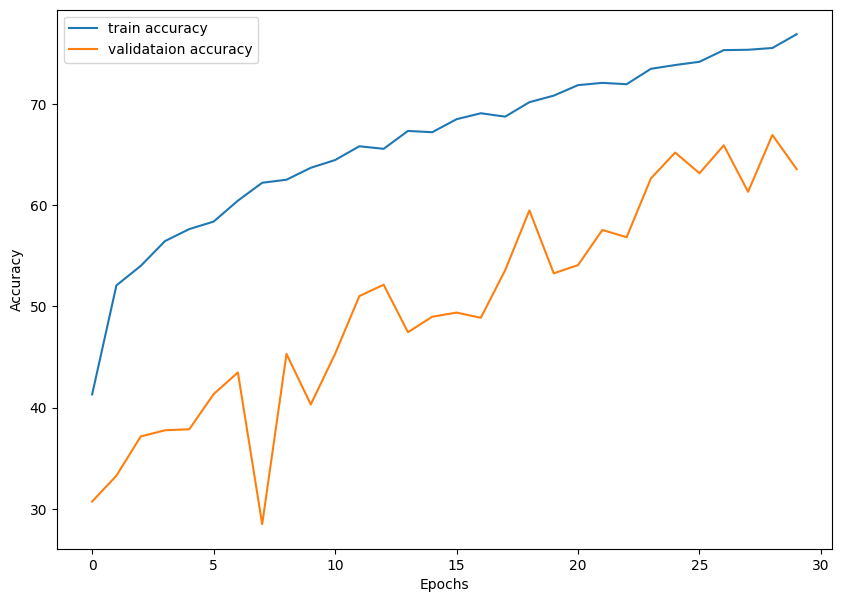

In [12]:
# accuracy plots
plt.figure(figsize=(10, 7))
plt.plot(
    train_acc, linestyle='-', 
    label='train accuracy'
)
plt.plot(
    valid_acc, linestyle='-', 
    label='validataion accuracy'
)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

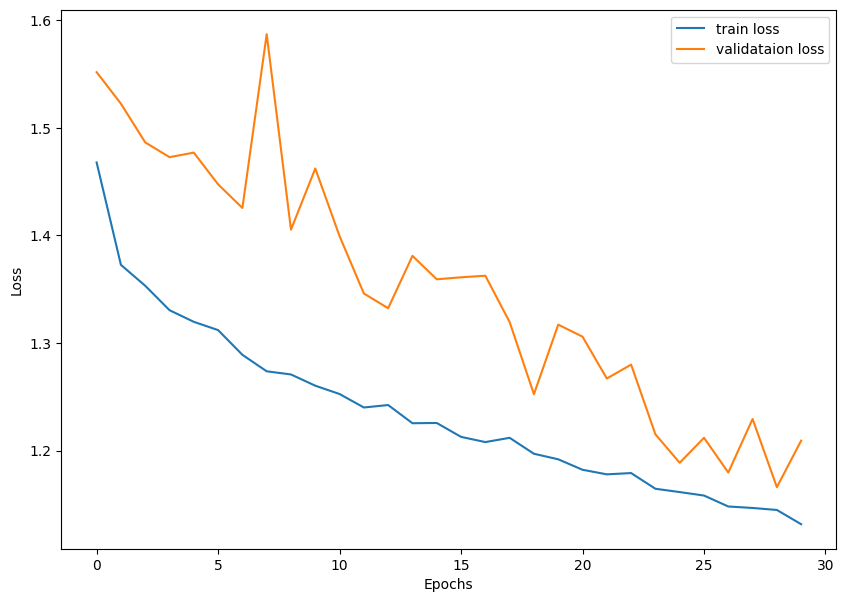

In [13]:
# loss plots
plt.figure(figsize=(10, 7))
plt.plot(
    train_loss, linestyle='-', 
    label='train loss')
plt.plot(
    valid_loss, linestyle='-', 
    label='validataion loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

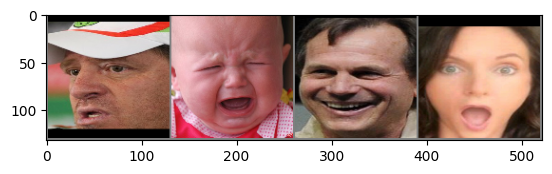

Real value:
Neutral	 Sad	 Happy	 Surprise	
Predicted value:
Neutral	 Sad	 Happy	 Surprise	


In [20]:
test_fetures, test_labels = next(iter(test_dataloader))
images = []
for i in range(4):
    images.append(test_fetures[i])
imshow(torchvision.utils.make_grid(images)) # show images
print("Real value:")
print(' '.join(f'{train_ds.classes[test_labels[j]]}\t' for j in range(4))) # print labels
print("Predicted value:")
print(' '.join(f'{train_ds.classes[model(test_fetures[j].view(1, 3, 128, 128).to(device)).argmax()]}\t' for j in range(4)))

In [15]:
real_labels = []
predicted_labels = []
for data, labels in test_dataloader:
    data = data.to(device)
    output = model(data).argmax(dim=1).cpu().detach().numpy()
    for i in range(len(output)):
        predicted_labels.append(output[i])
        real_labels.append(labels[i].detach().item())

In [16]:
from sklearn.metrics import classification_report

print(classification_report(predicted_labels, real_labels, target_names=test_ds.classes))

              precision    recall  f1-score   support

       Angry       0.42      0.87      0.57       269
       Happy       0.92      0.79      0.85       725
     Neutral       0.72      0.56      0.63       832
         Sad       0.76      0.68      0.72       915
    Surprise       0.72      0.86      0.79       459

    accuracy                           0.72      3200
   macro avg       0.71      0.75      0.71      3200
weighted avg       0.75      0.72      0.72      3200

